In [1]:
from transformers import AutoTokenizer
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Let's grab the emotions data

In [8]:
!pip install datasets
from datasets import load_dataset
emotions = load_dataset("emotion")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [9]:
import pandas as pd
import matplotlib.pyplot as plt

In [11]:

def tokenize(batch):
  return tokenizer(batch["text"], padding=True, truncation=True)

print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [13]:
emotions_encoded = emotions.map(tokenize,batched=True, batch_size=None)


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [14]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


Using a Transformer as a Feature Extractor

In [16]:
from transformers import AutoModel
import torch

# we already have the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)
print(f"We're using {device} as the device")


We're using cpu as the device


Extracing the (last) hidden state

In [17]:
text = "This is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")


Input tensor shape: torch.Size([1, 6])


In [18]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
  outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]]), hidden_states=None, attentions=None)


In [19]:
def extract_hidden_states(batch):
  inputs = {k:v.to(device) for k,v in batch.items()
            if k in tokenizer.model_input_names}
  # extract the state
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state
  return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [20]:
emotions_encoded.set_format("torch",columns=["input_ids","attention_mask","label"])


In [21]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)
emotions_hidden["train"].column_names


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

Creating a feature matrix -- to extract features.

In [23]:
import numpy as np
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape


((16000, 768), (2000, 768))

In [42]:
!pip uninstall umap
!pip install umap-learn
from umap.umap_ import UMAP
from sklearn.preprocessing import MinMaxScaler

X_scaled = MinMaxScaler().fit_transform(X_train)
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# create a dataframe
df_emb = pd.DataFrame(mapper.embedding_, columns=["X","Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.223601,6.208004,0
1,-2.999595,5.475529,0
2,5.335036,2.577438,3
3,-2.433984,2.940105,2
4,-3.342240,3.567625,3


Time to look at the various categories graphically.

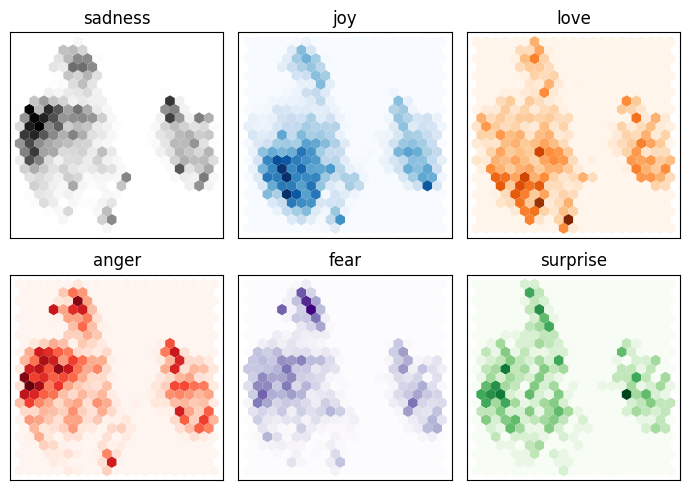

In [45]:
fig, axes = plt.subplots(2,3,figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label,cmap) in enumerate(zip(labels, cmaps)):
  df_emb_sub = df_emb.query(f"label == {i}")
  axes[i].hexbin(df_emb_sub["X"],df_emb_sub["Y"],cmap=cmap, gridsize=20, linewidths=(0,))
  axes[i].set_title(label)
  axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

Time to train a classifier on these hidden states

In [46]:
from sklearn.linear_model import LogisticRegression

# we increaese max_iter to ensure convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train,y_train)
lr_clf.score(X_valid,y_valid)

0.6335

We should compare this against a baseline, in this case we can use the **DummyClassifier**.

In [47]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train,y_train)
dummy_clf.score(X_valid,y_valid)

0.352

So this is actually, **significantly, better**.